In [1]:
!pip install xgboost tensorflow keras seaborn matplotlib

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached matplotlib-3.10.7-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.60.1-cp313-cp313-win_amd64.whl.metadata (114 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-win_amd64.whl.metadata (6.4 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached matplotlib-3.10.7-cp313-cp313-win_amd64.whl (8.1 MB)
Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl (226 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.60.1-cp313-cp313-win_amd64.whl (2.3 MB)
Using cached kiwisolver-1.4.9-cp313-cp313-win_amd64.whl (73 kB)
Using cached pyparsing-3.2.5-py3-none-any.whl (113 kB)

   ---------------------------------------- 0/7 [pyparsing]
   -----------------


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (confusion_matrix, classification_report, 
                             roc_curve, auc, precision_recall_curve, average_precision_score)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Set plot style for nicer images
sns.set(style="whitegrid")


In [3]:
# 1. Load the BALANCED dataset
df = pd.read_csv("dataset_3_balanced_mixed.csv")

y = df['TARGET']
X = df.drop(columns=['TARGET'])

print(f"Dataset shape: {X.shape}")
print(f"Target distribution (Should be balanced):\n{y.value_counts()}")

# 2. Impute (Fill missing values with 0)
imputer = SimpleImputer(strategy='constant', fill_value=0)
X_imputed = imputer.fit_transform(X)

# 3. Split Data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.2, random_state=42
)

# 4. Scale Data (Fit on Train, Transform both)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✅ Data processed and scaled.")

Dataset shape: (5022, 18)
Target distribution (Should be balanced):
TARGET
1    2511
0    2511
Name: count, dtype: int64

✅ Data processed and scaled.


In [4]:
def evaluate_model(model, X_test, y_test, model_name, is_deep_learning=False):
    """
    Generates Confusion Matrix, ROC Curve, and PR Curve for a given model.
    """
    # 1. Get Predictions
    if is_deep_learning:
        # Deep learning returns probabilities by default
        y_pred_proba = model.predict(X_test).ravel() 
        y_pred = (y_pred_proba > 0.5).astype(int)   # Convert prob to 0/1
    else:
        # Sklearn models
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

    # 2. Create Figure
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    plt.suptitle(f"Performance Analysis: {model_name}", fontsize=16)

    # --- PLOT 1: Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False)
    axes[0].set_title('Confusion Matrix')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('Actual Label')
    axes[0].set_xticklabels(['Non-Essential', 'Essential'])
    axes[0].set_yticklabels(['Non-Essential', 'Essential'])

    # --- PLOT 2: ROC Curve ---
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1].set_title('ROC Curve')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].legend(loc="lower right")

    # --- PLOT 3: Precision-Recall Curve ---
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    avg_precision = average_precision_score(y_test, y_pred_proba)
    axes[2].plot(recall, precision, color='green', lw=2, label=f'AP = {avg_precision:.2f}')
    axes[2].set_title('Precision-Recall Curve')
    axes[2].set_xlabel('Recall')
    axes[2].set_ylabel('Precision')
    axes[2].legend(loc="upper right")

    plt.tight_layout()
    plt.show()
    
    # Print classification report for detailed numbers
    print(f"\n--- Classification Report: {model_name} ---")
    print(classification_report(y_test, y_pred, target_names=['Non-Essential', 'Essential']))

Training Random Forest...


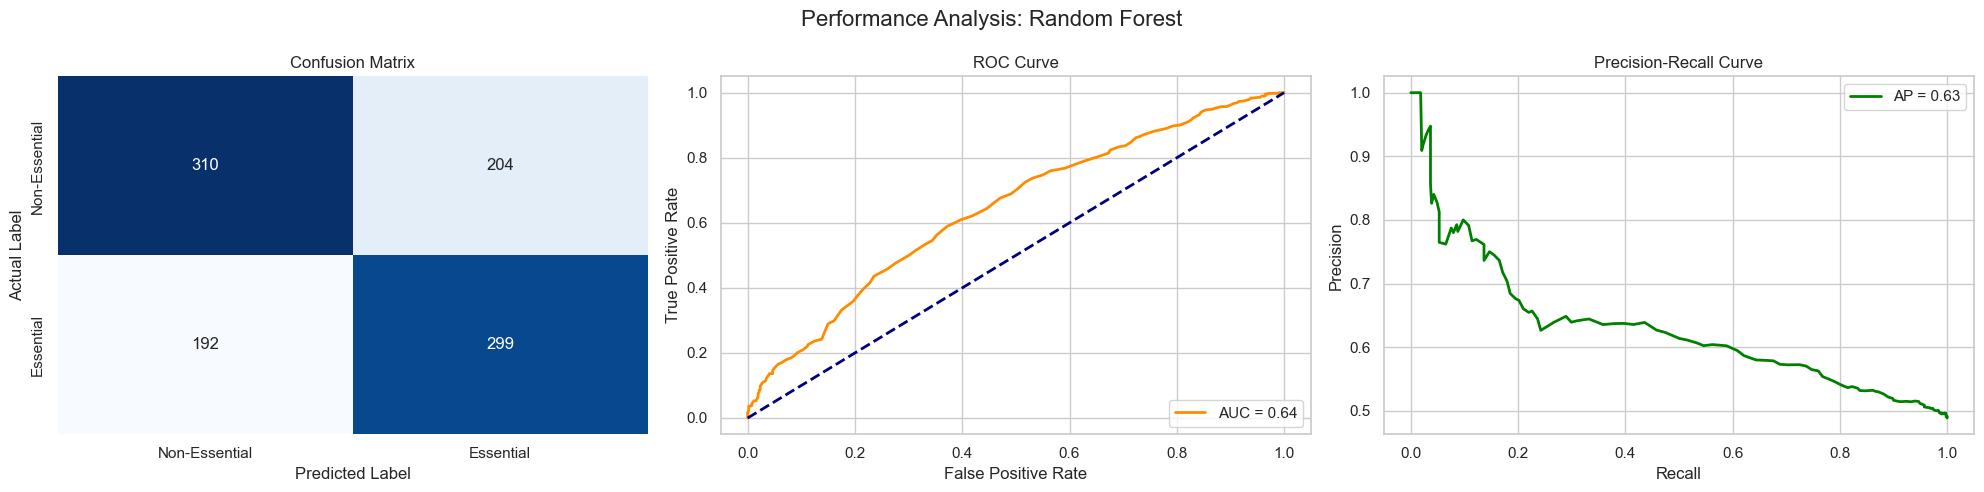


--- Classification Report: Random Forest ---
               precision    recall  f1-score   support

Non-Essential       0.62      0.60      0.61       514
    Essential       0.59      0.61      0.60       491

     accuracy                           0.61      1005
    macro avg       0.61      0.61      0.61      1005
 weighted avg       0.61      0.61      0.61      1005



In [5]:
print("Training Random Forest...")
# You can add parameters here if you have tuned them (e.g., n_estimators=300)
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)

rf_model.fit(X_train_scaled, y_train)

# Visualize Results
evaluate_model(rf_model, X_test_scaled, y_test, "Random Forest")

Training XGBoost...


d:\python_progs\Final_year_proj\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [22:44:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


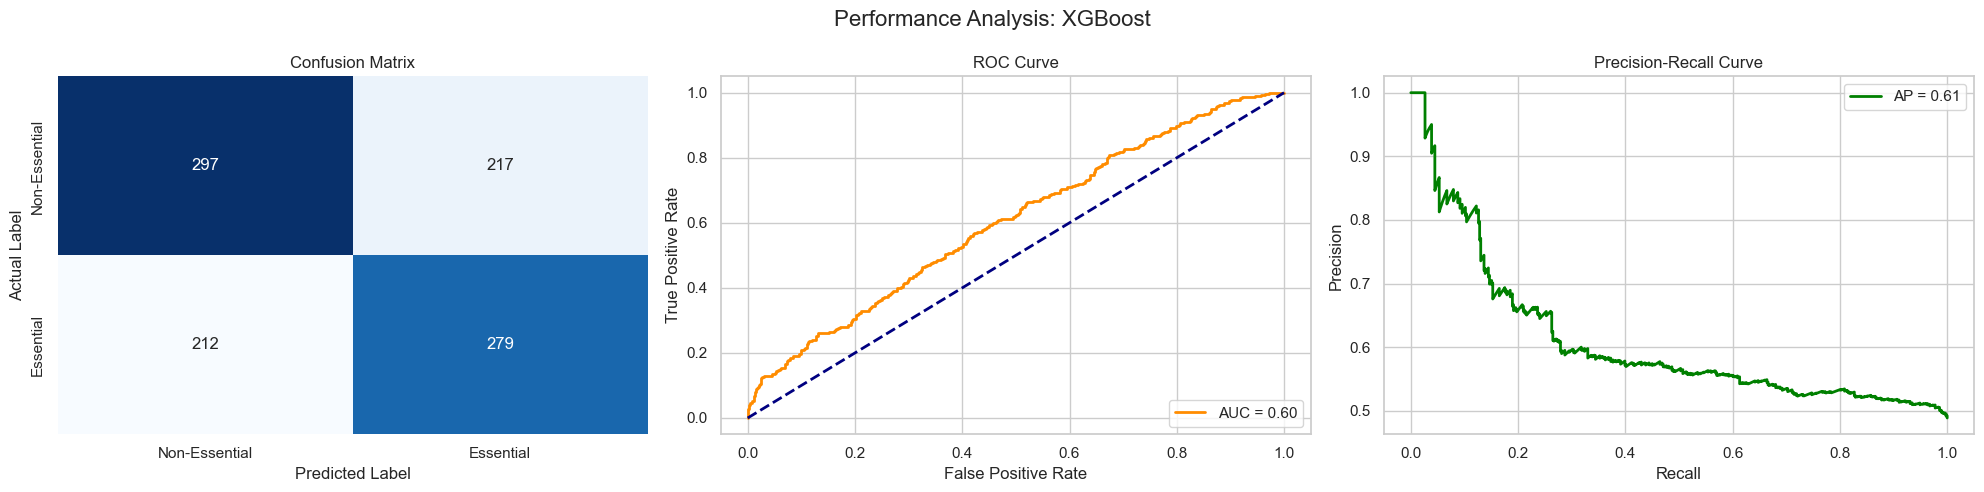


--- Classification Report: XGBoost ---
               precision    recall  f1-score   support

Non-Essential       0.58      0.58      0.58       514
    Essential       0.56      0.57      0.57       491

     accuracy                           0.57      1005
    macro avg       0.57      0.57      0.57      1005
 weighted avg       0.57      0.57      0.57      1005



In [6]:
print("Training XGBoost...")
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

xgb_model.fit(X_train_scaled, y_train)

# Visualize Results
evaluate_model(xgb_model, X_test_scaled, y_test, "XGBoost")

Training Deep Learning MLP...


d:\python_progs\Final_year_proj\.venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


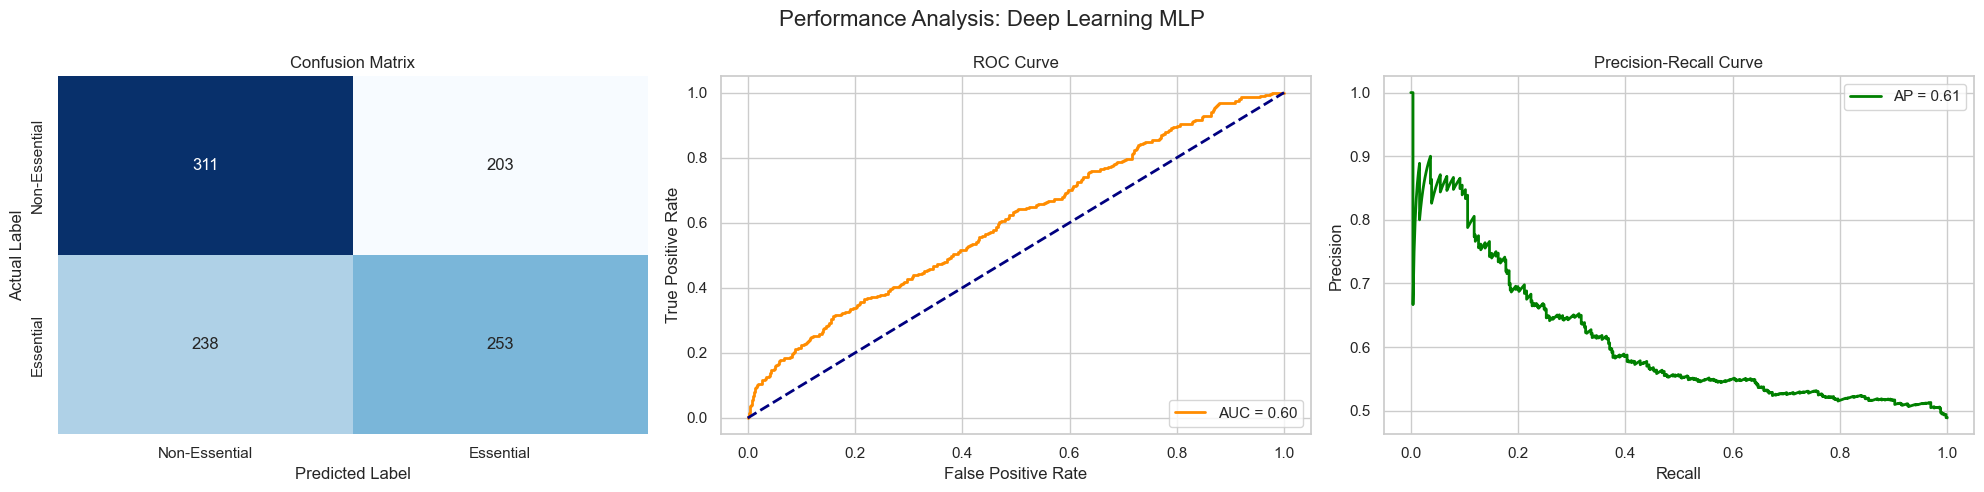


--- Classification Report: Deep Learning MLP ---
               precision    recall  f1-score   support

Non-Essential       0.57      0.61      0.59       514
    Essential       0.55      0.52      0.53       491

     accuracy                           0.56      1005
    macro avg       0.56      0.56      0.56      1005
 weighted avg       0.56      0.56      0.56      1005



In [7]:
print("Training Deep Learning MLP...")

# Define Model Structure
mlp_model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

# Compile
mlp_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train
history = mlp_model.fit(
    X_train_scaled, y_train,
    batch_size=32,
    epochs=50,
    validation_split=0.2,
    verbose=0  # Set to 1 to see training progress bars
)

# Visualize Results (Note: is_deep_learning=True)
evaluate_model(mlp_model, X_test_scaled, y_test, "Deep Learning MLP", is_deep_learning=True)